In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.3 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install rfdetr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 6.0 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━

2025-04-23 04:54:52.390612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745384092.779988      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745384092.897553      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
rf-detr-base.pth: 100%|██████████| 355M/355M [00:03<00:00, 102MiB/s]  


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Loading pretrain weights


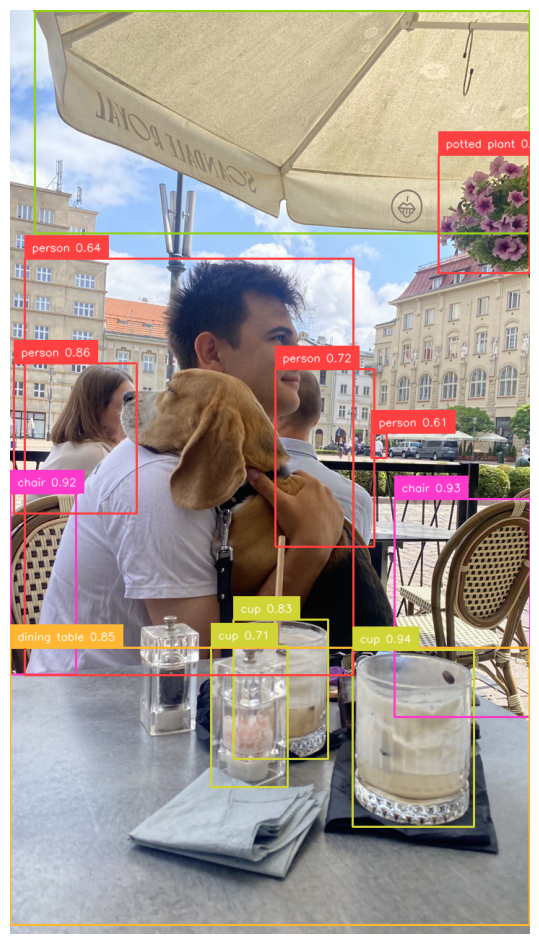

In [3]:
import io
import requests
import supervision as sv
from PIL import Image
from rfdetr import RFDETRBase
from rfdetr.util.coco_classes import COCO_CLASSES

model = RFDETRBase()

url = "https://media.roboflow.com/notebooks/examples/dog-2.jpeg"

image = Image.open(io.BytesIO(requests.get(url).content))
detections = model.predict(image, threshold=0.5)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels)

sv.plot_image(annotated_image)

In [9]:
# Create a temporary script file for the distributed training
with open('ddp_train.py', 'w') as f:
    f.write("""
import os
import sys
import torch
from rfdetr import RFDETRBase

def main():
    # Get local rank from environment variable
    local_rank = int(os.environ.get('LOCAL_RANK', 0))
    world_size = int(os.environ.get('WORLD_SIZE', 1))
    
    # Don't initialize distributed here - let the model handle it
    # Print basic info
    print(f"Process {local_rank} of {world_size} starting")
    
    # Create model
    model = RFDETRBase(resolution=560, device='cuda')
    
    # Call train directly with distributed parameters
    # The model will handle distributed setup internally
    model.train(
        dataset_dir="/kaggle/input/parking-lot-detection-coco",
        epochs=5,
        batch_size=3,  # Per GPU batch size
        grad_accum_steps=2,
        lr=3e-3,
        output_dir="/kaggle/working/",
        # Add distributed-specific args that will be passed to internal init_distributed_mode
        distributed=True,  # Enable distributed mode
        dist_url='env://',  # Use environment variables for addressing
        world_size=world_size,
        rank=local_rank  # Pass local rank as global rank
    )

if __name__ == "__main__":
    main()
""")

# Run using torchrun with environment variables
!torchrun --nproc_per_node=2 ddp_train.py

W0423 05:11:17.087000 448 torch/distributed/run.py:793] 
W0423 05:11:17.087000 448 torch/distributed/run.py:793] *****************************************
W0423 05:11:17.087000 448 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0423 05:11:17.087000 448 torch/distributed/run.py:793] *****************************************
2025-04-23 05:11:22.012271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745385082.034672     450 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745385082.041308     450 cuda_blas.cc:1418] Unable to register cuBLAS factory: Atte

In [ ]:
from rfdetr import RFDETRBase
model = RFDETRBase(resolution=560)

In [ ]:
from rfdetr import RFDETRBase

model = RFDETRBase()

model.train(dataset_dir="/kaggle/input/parking-lot-detection-coco", epochs=10, batch_size=3, grad_accum_steps=3, lr=3e-3, output_dir="/kaggle/working/")

In [10]:
from rfdetr import RFDETRBase

model = RFDETRBase(pretrain_weights="/kaggle/working/checkpoint_best_ema.pth")

detections = model.predict("/kaggle/input/parking-lot-detection-coco/test/2012-09-16_06_47_56_jpg.rf.c2a712d9f98940027a570457f529ce7f.jpg")

Loading pretrain weights


In [11]:
detections

Detections(xyxy=array([[ 70.49544 , 443.60956 , 106.86126 , 502.09937 ],
       [148.06616 , 445.23544 , 182.75865 , 502.2928  ],
       [123.55468 , 443.46832 , 159.57834 , 503.01956 ],
       [ 94.805145, 443.5986  , 132.00996 , 502.7132  ],
       [ 19.774258, 444.04187 ,  55.38759 , 495.32956 ],
       [523.3747  , 371.8623  , 552.3613  , 432.17258 ],
       [ 43.92847 , 443.38043 ,  80.28675 , 497.75925 ],
       [428.13754 , 371.73944 , 454.35428 , 429.1754  ],
       [475.7556  , 371.93457 , 503.4604  , 431.77344 ],
       [204.03708 , 447.2009  , 238.04    , 501.66415 ],
       [381.1963  , 370.76593 , 405.91202 , 427.5444  ],
       [229.54575 , 449.12115 , 264.16156 , 505.05304 ],
       [266.94824 , 373.21545 , 293.9973  , 426.37027 ],
       [202.16193 , 369.4153  , 229.8413  , 422.32312 ],
       [358.06097 , 371.23703 , 382.10098 , 426.68442 ],
       [286.696   , 448.61963 , 315.03717 , 505.31586 ],
       [500.01868 , 373.28192 , 528.23553 , 432.45346 ],
       [545.493

Loading pretrain weights
Sample detection: Detections(xyxy=array([[148.4977 , 445.39862, 182.03214, 499.74554]], dtype=float32), mask=None, confidence=array([0.8943113], dtype=float32), class_id=array([1]), tracker_id=None, data={}, metadata={})


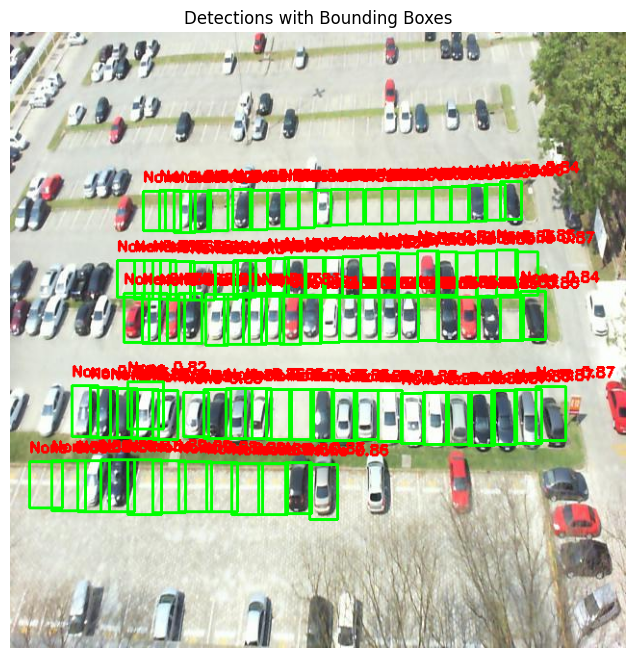

In [12]:
import matplotlib.pyplot as plt
import cv2
from rfdetr import RFDETRBase

# Load model and run prediction
model = RFDETRBase(pretrain_weights="/kaggle/working/checkpoint_best_ema.pth")
image_path = "/kaggle/input/parking-lot-detection-coco/test/2012-09-17_13_44_09_jpg.rf.1d30119bf2b0b1488998d167a3a3e68d.jpg"
detections = model.predict(image_path)

# Read and convert image to RGB
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Print sample detection
print("Sample detection:", detections[0])

# Draw detections
for det in detections:
    bbox, label, score, *_ = det  # unpack only the needed parts
    x1, y1, x2, y2 = map(int, bbox)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    text = f"{label} {score:.2f}"
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (255, 0, 0), 2)

# Display image with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis("off")
plt.title("Detections with Bounding Boxes")
plt.show()


Loading pretrain weights
Sample detection: Detections(xyxy=array([[148.4977 , 445.39862, 182.03214, 499.74554]], dtype=float32), mask=None, confidence=array([0.8943113], dtype=float32), class_id=array([1]), tracker_id=None, data={}, metadata={})


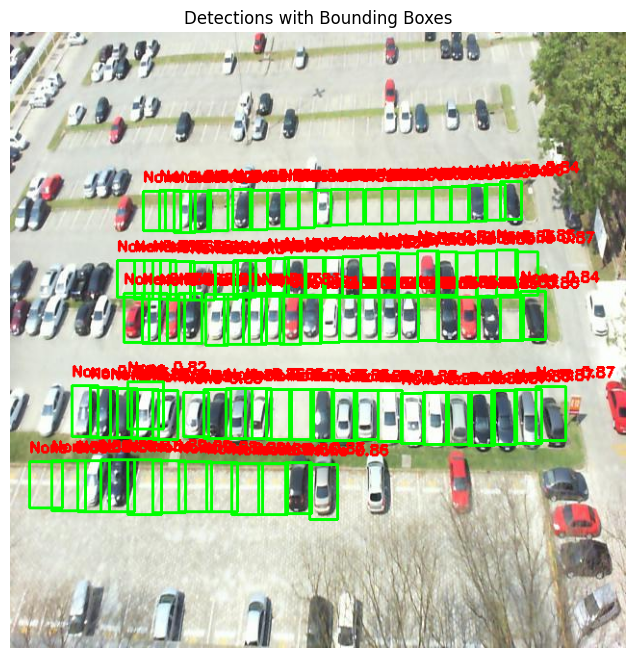

In [14]:
import matplotlib.pyplot as plt
import cv2
from rfdetr import RFDETRBase

# Load model and run prediction
model = RFDETRBase(pretrain_weights="/kaggle/working/checkpoint_best_total.pth")
image_path = "/kaggle/input/parking-lot-detection-coco/test/2012-09-17_13_44_09_jpg.rf.1d30119bf2b0b1488998d167a3a3e68d.jpg"
detections = model.predict(image_path)

# Read and convert image to RGB
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Print sample detection
print("Sample detection:", detections[0])

# Draw detections
for det in detections:
    bbox, label, score, *_ = det  # unpack only the needed parts
    x1, y1, x2, y2 = map(int, bbox)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    text = f"{label} {score:.2f}"
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (255, 0, 0), 2)

# Display image with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis("off")
plt.title("Detections with Bounding Boxes")
plt.show()


Loading pretrain weights
Sample detection: Detections(xyxy=array([[312.6023, 447.627 , 340.6995, 503.4755]], dtype=float32), mask=None, confidence=array([0.8452251], dtype=float32), class_id=array([2]), tracker_id=None, data={}, metadata={})


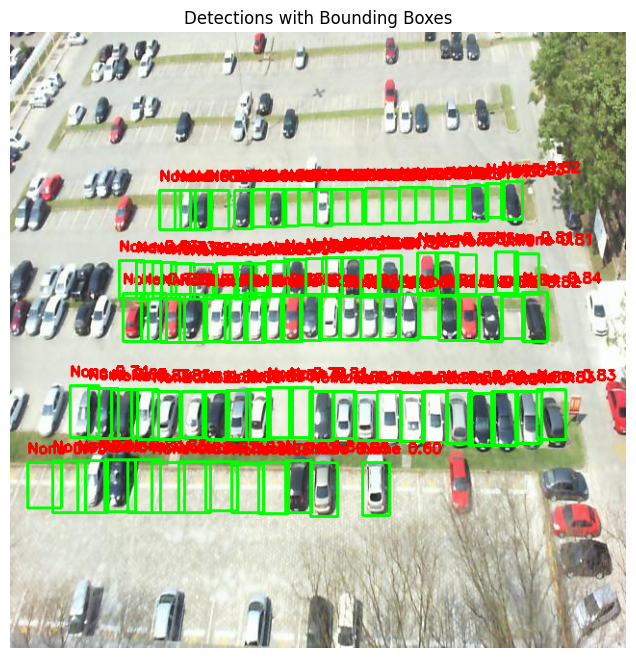

In [15]:
import matplotlib.pyplot as plt
import cv2
from rfdetr import RFDETRBase

# Load model and run prediction
model = RFDETRBase(pretrain_weights="/kaggle/working/checkpoint_best_regular.pth")
image_path = "/kaggle/input/parking-lot-detection-coco/test/2012-09-17_13_44_09_jpg.rf.1d30119bf2b0b1488998d167a3a3e68d.jpg"
detections = model.predict(image_path)

# Read and convert image to RGB
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Print sample detection
print("Sample detection:", detections[0])

# Draw detections
for det in detections:
    bbox, label, score, *_ = det  # unpack only the needed parts
    x1, y1, x2, y2 = map(int, bbox)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    text = f"{label} {score:.2f}"
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (255, 0, 0), 2)

# Display image with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis("off")
plt.title("Detections with Bounding Boxes")
plt.show()
